In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv

In [2]:
learning_rate, hidden_size, num_layers, batch_size, ct= 5e-3, 128, 1, 256, '12-09-21-44'

code = f"LR{int(learning_rate*100000)}_HS{hidden_size}_NL{num_layers}_BS{batch_size} {ct}"
Predicteddata  = torch.load(os.path.join(os.getcwd(),'Pickled', code + 'Predicteddata.pt'), weights_only=True)
ActualTarget = torch.load(os.path.join(os.getcwd(),'Pickled', 'Test', 'Target.pt'), weights_only=True)
ActualScene = torch.load(os.path.join(os.getcwd(),'Pickled', 'Test', 'Scene.pt'), weights_only=True)
Adj_Mat_Scene = torch.load(os.path.join(os.getcwd(),'Pickled', 'Test', 'Adj_Mat_Scene.pt'), weights_only=True)
Adj_Mat_Target = torch.load(os.path.join(os.getcwd(),'Pickled', 'Test', 'Adj_Mat_Target.pt'), weights_only=True)
test_loss = torch.load(os.path.join(os.getcwd(),'Pickled', code + 'test_losses.pt'), weights_only=True)
epoch_losses = torch.load(os.path.join(os.getcwd(),'Pickled', code + 'epoch_losses.pt'), weights_only=True)

In [4]:
from utilz.utils import *
import argparse
cwd = os.getcwd()
# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
# # Hyperparameters
hidden_size, num_layersGAT, num_layersGRU, expansion,  n_heads = 128, 1, 6, 2, 8

learning_rate, schd_stepzise, gamma, epochs, batch_size, patience_limit, clip= 5e-2, 15, 0.50, 200, 512, 10, 1

Headers = ['Frame', 'ID', 'BBx', 'BBy','W', 'L' , 'Cls','Tr1', 'Tr2', 'Tr3', 'Tr4', 'Zone', 'Xreal', 'Yreal']
Columns_to_keep = [2,3,7,8,9,10,11] #['BBx', 'BBy','W', 'L' , 'Cls','Tr1', 'Tr2', 'Tr3', 'Tr4']
#  ['Vx', 'Vy', 'heading',xc,yc, Rc,Rc, SinX,CosX,SinY,CosY, Sin2X,Cos2X, Sin2Y, Cos2Y, Sin3X, Cos3X, Sin3Y, Cos3Y, Sin4X, Cos4X, Sin4Y, Cos4Y]
Columns_to_Predict = [0,1] #['BBx', 'BBy','Xreal', 'Yreal','Vx', 'Vy']
xyid = [0, 1] # the index of x and y  of the Columns_to_Keep in the columns for speed calculation
TrfL_Columns = [7,8,9,10]
NFeatures = len(Columns_to_keep)
input_size = NFeatures
output_size = len(Columns_to_Predict)
Nusers, NZones = 32, 10
Nnodes, NTrfL, sl, future, sw, sn  = NZones + Nusers, 4, 20, 30, 2, 5
Centre = [512,512]

sos = torch.tensor([1022,1022], device=device)
eos = torch.tensor([1021,1021], device=device)

generate_data = False #  Add class by loading the CSV file
# generate_data = True #  Add class by loading the CSV file
loadData = not generate_data      # load the class from the saved file
Train = True # It's for training the model with the prepared data
test_in_epoch = True # It's for testing the model in each epoch
model_from_scratch = True # It's for creating model from scratch
load_the_model = not model_from_scratch # It's for loading model
Seed = loadData # If true, it will use the predefined seed to load the indices
only_test = False # It's for testing the model only
concat = False
    
parser = argparse.ArgumentParser(description='Trajectory Prediction')
parser.add_argument('--Nfeatures', type=int, default=NFeatures, help='Number of features')
parser.add_argument('--Nnodes', type=int, default=Nnodes, help='Number of nodes')
parser.add_argument('--NZones', type=int, default=NZones, help='Number of zones')
parser.add_argument('--NTrfL', type=int, default=NTrfL, help='Number of traffic lights')
parser.add_argument('--sl', type=int, default=sl, help='Sequence length')
parser.add_argument('--future', type=int, default=future, help='Future length')
parser.add_argument('--sw', type=int, default=sw, help='Sliding window')
parser.add_argument('--sn', type=int, default=sn, help='Sliding number')
parser.add_argument('--Columns_to_keep', type=list, default=Columns_to_keep, help='Columns to keep')
parser.add_argument('--Columns_to_Predict', type=list, default=Columns_to_Predict, help='Columns to predict')
parser.add_argument('--TrfL_Columns', type=list, default=TrfL_Columns, help='Traffic light columns')
parser.add_argument('--Nusers', type=int, default=Nusers, help='Number of maneuvers')
parser.add_argument('--sos', type=int, default=sos, help='Start of sequence')
parser.add_argument('--eos', type=int, default=eos, help='End of sequence')
parser.add_argument('--xyidx', type=list, default=xyid, help='X and Y index')
parser.add_argument('--Centre', type=list, default=Centre, help='Centre')

parser.add_argument('--input_size', type=int, default=input_size, help='Input size')
parser.add_argument('--hidden_size', type=int, default=hidden_size, help='Hidden size')
parser.add_argument('--num_layersGAT', type=int, default=num_layersGAT, help='Number of layers')
parser.add_argument('--num_layersGRU', type=int, default=num_layersGRU, help='Number of layers')
parser.add_argument('--output_size', type=int, default=output_size, help='Output size')
parser.add_argument('--n_heads', type=int, default=n_heads, help='Number of heads')
parser.add_argument('--concat', type=bool, default=concat, help='Concat')
parser.add_argument('--dropout', type=float, default=0.001, help='Dropout')
parser.add_argument('--leaky_relu_slope', type=float, default=0.2, help='Leaky relu slope')
parser.add_argument('--expansion', type=int, default=expansion, help='Expantion')


parser.add_argument('--epochs', type=int, default=epochs, help='Number of epochs')
parser.add_argument('--learning_rate', type=float, default=learning_rate, help='Learning rate')
parser.add_argument('--batch_size', type=int, default=batch_size, help='Batch size')
parser.add_argument('--patience_limit', type=int, default=patience_limit, help='Patience limit')
parser.add_argument('--schd_stepzise', type=int, default=schd_stepzise, help='Scheduler step size')
parser.add_argument('--gamma', type=float, default=gamma, help='Scheduler Gamma')


parser.add_argument('--only_test', type=bool, default=only_test, help='Only test')
parser.add_argument('--generate_data', type=bool, default=generate_data, help='Generate data')
parser.add_argument('--loadData', type=bool, default=loadData, help='Load data')
parser.add_argument('--Train', type=bool, default=Train, help='Train')
parser.add_argument('--test_in_epoch', type=bool, default=test_in_epoch, help='Test in epoch')
parser.add_argument('--model_from_scratch', type=bool, default=model_from_scratch, help='Model from scratch')
parser.add_argument('--load_the_model', type=bool, default=load_the_model, help='Load the model')
parser.add_argument('--Seed', type=bool, default=Seed, help='Seed')
parser.add_argument('--device', type=str, default=device, help='device')

args = parser.parse_args(args=[])
Scenetr = Scenes(args, 0)
Scenetst = Scenes(args, 1)
cwd = os.getcwd()
dataset_path = os.path.join(cwd, 'Pickled')
Scenetr.load_class(dataset_path, cmnt = 'Train')
Scenetst.load_class(dataset_path, cmnt = 'Test')


/home/abdikhab/New_Idea_Traj_Pred/utilz/utils.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Scene = torch.load(os.path.join(path, cmnt, 'Scene.pt')) #, weights_

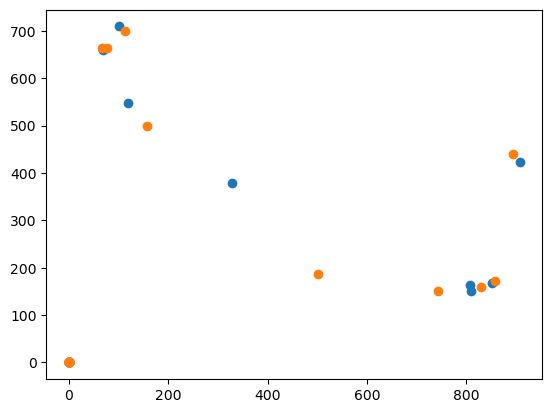

In [29]:
import matplotlib.pyplot as plt

Predicteddata.shape
ActualTarget.shape

m= 20

Xpred = Predicteddata[m,0,:,0].softmax(-1).argmax(-1).cpu().detach().numpy()
Ypred = Predicteddata[m,0,:,1].softmax(-1).argmax(-1).cpu().detach().numpy()
Xact = ActualTarget[m,-2,:,1].cpu().detach().numpy()
Yact = ActualTarget[m,-2,:,2].cpu().detach().numpy()

Pred = np.stack([Xpred, Ypred], axis = 1)
Act = np.stack([Xact, Yact], axis = 1)
all = np.concatenate([Pred, Act], axis = 1)

plt.scatter(Xpred, Ypred)
plt.scatter(Xact, Yact)




In [30]:
all

array([[101., 709., 113., 699.],
       [810., 150., 744., 150.],
       [120., 547., 158., 500.],
       [ 68., 660.,  77., 664.],
       [  0.,   0.,   0.,   0.],
       [908., 422., 894., 439.],
       [328., 378., 501., 187.],
       [  0.,   0.,  66., 663.],
       [  0.,   0.,   0.,   0.],
       [808., 164., 830., 160.],
       [852., 168., 859., 172.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  

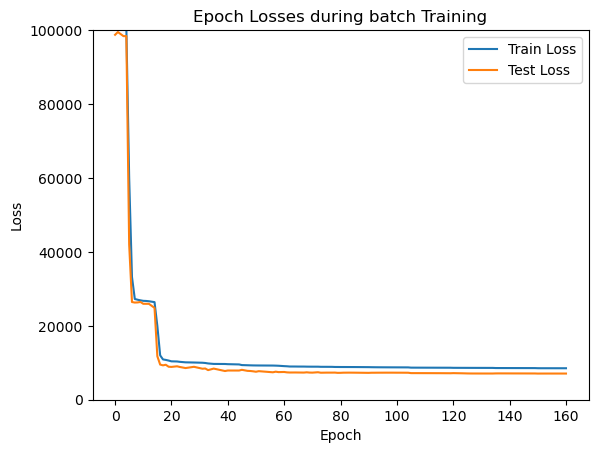

In [5]:
# Plotting the loss
trainloss = []
testloss = []
epochs = []
for obj in test_loss:
    trainloss.append(epoch_losses[obj[1]])
    testloss.append(obj[0])
    epochs.append(obj[1])
plt.plot(epochs, trainloss)
plt.title('Epoch Losses during batch Training')
plt.plot(epochs, testloss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])
plt.ylim(0, 100000)
plt.show()

***Now, we want to predict the future sequence using the best model***

In [8]:
from utilz.utils import *
import torch.nn.functional as F

Best_Model=torch.load(os.path.join(os.getcwd(),'Processed', code + 'Bestmodel.pth'))
# Best_Model_dict = Best_Model.state_dict()

# Model = GGAT(args)
# Model.load_state_dict(Best_Model_dict)

/tmp/ipykernel_2304257/3273961488.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Best_Model=torch.load(os.path.join(os.getcwd(),'Processed', code + 'Bestmodel.pth'))


In [9]:
def eval(model, Scene, Adj_mat, h0, Nseq):
    # savelog("Starting testing phase", ct)
    model.eval()
    with torch.no_grad():
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        Out, Gruh0 = model(Scene, Adj_mat, h0, Nseq)
        end_event.record()
        torch.cuda.synchronize()
        inference_time = start_event.elapsed_time(end_event)
    return Out, Gruh0, inference_time

In [10]:
def attach(NScene, Scenelet, Zonecft):
    x,y = NScene[:,:,0], NScene[:,:,1]

    dx = torch.diff(x, n=1, append=x[-1:,:], dim = 0).unsqueeze(2)
    dy = torch.diff(y, n=1, append=y[-1:,:], dim = 0).unsqueeze(2)
    heading = torch.atan2(dy, dx)
    xc = x - 512
    yc = y - 512
    Rc = torch.sqrt(xc**2 + yc**2).unsqueeze(2)
    SinX = torch.sin(xc/512).unsqueeze(2)
    CosY = torch.cos(yc/512).unsqueeze(2)
    SinY = torch.sin(yc/512).unsqueeze(2)
    CosX = torch.cos(xc/512).unsqueeze(2)
    Sin2X = torch.sin(2*xc/512).unsqueeze(2)
    Cos2X = torch.cos(2*xc/512).unsqueeze(2)
    Sin2Y = torch.sin(2*yc/512).unsqueeze(2)
    Cos2Y = torch.cos(2*yc/512).unsqueeze(2)


    NScene = torch.cat((NScene, Scenelet, dx, dy, heading, xc.unsqueeze(2),yc.unsqueeze(2), Rc,
                            SinX, CosX, SinY, CosY,
                            Sin2X, Cos2X, Sin2Y, Cos2Y), dim=2)
    for i in range(NScene.size(1)):
        NScene[:,i,9] = torch.tensor(zonefinder(NScene[0,i,:2].cpu().numpy(), Zonecft), device=NScene.device)
    return NScene

def Zoneconf():
    ZoneConf = []
    with open('utilz/ZoneConf.yaml') as file:
        ZonesYML = yaml.load(file, Loader=yaml.FullLoader)
        #convert the string values to float
        for _, v in ZonesYML.items():
            lst = []
            for _, p  in v.items():    
                for x in p[0]:
                    b = re.split(r'[,()]',p[0][x])
                    lst.append((float(b[1]), float(b[2])))
            ZoneConf.append(lst)
    return ZoneConf

def zonefinder(BB, Zones):
    for i, zone in enumerate(Zones):
        Poly = Polygon(zone)
        if Poly.contains(Point(BB[0], BB[1])):
            return i
    return 100

The following code is for the case only one time step is going to be passed through the model

In [ ]:
def scene_eval(Best_Model, Scene, Adj_Mat,Target, future, Zonecft):
    Pred = []
    total_time = 0
    NScene, GRUh0, inference_time = eval(Best_Model, Scene[:,-20:,:,:], Adj_Mat[:,:20,:32,:32], None, False)
    Pred.append(NScene)
    NScene = attach(NScene, Target[:,0,:,2:10], Zonecft).unsqueeze(0)
    # NScene = torch.cat((Scene[:,-19:,:,:],NScene), dim=1)
    
    for f in range(future-1):
        # NScene1, GRUh0, inference_time = eval(Best_Model, NScene, Adj_Mat[:,f+1:f+21,:32,:32], GRUh0[:,0,:].unsqueeze(1), False)
        NScene1, GRUh0, inference_time = eval(Best_Model, NScene, Adj_Mat[:,f+1,:32,:32].unsqueeze(1), GRUh0, False)
        Pred.append(NScene1)
        NScene1 = attach(NScene1, Target[:,f+1,:,2:10], Zonecft).unsqueeze(0)
        # NScene = torch.cat((NScene[:,-19:,:,:], NScene1), dim=1)
        total_time += inference_time

    Pred = torch.stack(Pred, dim=1).to(torch.int)
    tag = Target[0,:,:,:2].unsqueeze(0) != 0
    Pred = Pred*(tag.to(torch.int))

    loss = F.mse_loss(Pred, Target[0,:,:,:2].unsqueeze(0))
    msePtime = torch.sqrt(torch.sum((Pred - Target[0,:,:,:2].unsqueeze(0)) ** 2, dim = -1)).sum(dim = -1)/32
    msePuser = torch.sqrt(torch.sum((Pred - Target[0,:,:,:2].unsqueeze(0)) ** 2, dim = -1)).sum(dim = 1)/future

    # print(f"loss: {loss.item()} and inference time: {total_time} ms")
    # print(f"mse per time step: {msePtime}")
    # print(f"mse per user: {msePuser}")
    return Pred, loss, msePtime.squeeze(0), msePuser.squeeze(0), total_time

In [13]:
def scene_eval20(Best_Model, Scene, Adj_Mat,Target, future, Zonecft):
    Pred = []
    total_time = 0
    NScene, GRUh0, inference_time = eval(Best_Model, Scene[:,-20:,:,:], Adj_Mat[:,:20,:32,:32], None, False)
    Pred.append(NScene)
    NScene = attach(NScene, Target[:,0,:,2:10], Zonecft).unsqueeze(0)
    NScene = torch.cat((Scene[:,-19:,:,:], NScene), dim=1)
    
    for f in range(future-1):
        NScene1, GRUh0, inference_time = eval(Best_Model, NScene, Adj_Mat[:,f+1:f+21,:32,:32], GRUh0[:,0,:].unsqueeze(1), False)
        Pred.append(NScene1)
        NScene1 = attach(NScene1, Target[:,f+1,:,2:10], Zonecft).unsqueeze(0)
        NScene = torch.cat((NScene[:,-19:,:,:], NScene1), dim=1)
        total_time += inference_time

    Pred = torch.stack(Pred, dim=1)
    tag = Target[0,:,:,:2].unsqueeze(0) != 0
    Pred = Pred*(tag.to(torch.int))

    loss = F.mse_loss(Pred, Target[0,:,:,:2].unsqueeze(0))
    msePtime = torch.sqrt(torch.sum((Pred - Target[0,:,:,:2].unsqueeze(0)) ** 2, dim = -1)).sum(dim = -1)/32
    msePuser = torch.sqrt(torch.sum((Pred - Target[0,:,:,:2].unsqueeze(0)) ** 2, dim = -1)).sum(dim = 1)/future

    # print(f"loss: {loss.item()} and inference time: {total_time} ms")
    # print(f"mse per time step: {msePtime}")
    # print(f"mse per user: {msePuser}")
    return Pred, loss, msePtime.squeeze(0), msePuser.squeeze(0), total_time

In [ ]:
future = 30
Prediction = []
totalmsePtime = torch.zeros(30, device=Adj_Mat_Scene.device)
totalmsePuser = torch.zeros(32, device=Adj_Mat_Scene.device)
total_loss = 0

total_time = 0
Adj_Mat = torch.cat((Adj_Mat_Scene, Adj_Mat_Target), dim=1).unsqueeze(0)
Zonecft = Zoneconf()
for n in range(250):
    Scene = ActualScene[n,1:,:32,:].unsqueeze(0)
    Target = ActualTarget[n,:,:32].unsqueeze(0)
    adj_mat = Adj_Mat[:,n,:,:32,:32]
    Pred, loss, msePtime, msePuser, elapsed_time = scene_eval(Best_Model, Scene, adj_mat, Target, future, Zonecft)
    totalmsePtime = totalmsePtime+ msePtime
    totalmsePuser = totalmsePuser+ msePuser
    total_loss += loss
    total_time += elapsed_time
    Prediction.append(Pred)

totalmsePtime = totalmsePtime/250
totalmsePuser = totalmsePuser/250
total_loss = total_loss/250
Prediction = torch.cat(Prediction, dim=0)
print(f"Total loss: {total_loss.item()}")
print(f"Total mse per time step: {totalmsePtime}")
print(f"Total mse per user: {totalmsePuser}")
print(f"Total inference time: {total_time/250} ms")
print("done")

Total loss: 51162.7578125
Total mse per time step: tensor([  1.2533,  17.5530,  43.1605,  84.1165, 101.2594, 110.9906, 122.6501,
        132.2537, 140.5811, 149.6402, 163.2494, 178.3671, 189.3534, 195.3384,
        199.0931, 203.0734, 203.8565, 207.4512, 204.9712, 210.7410, 214.2010,
        211.4090, 214.8859, 214.2756, 212.1995, 210.5334, 210.5607, 212.5746,
        217.3352, 222.1837], device='cuda:3')
Total mse per user: tensor([334.1521, 326.7867, 366.0444, 392.8058, 356.7054, 335.1273, 359.8518,
        368.0763, 315.3819, 287.8268, 294.1906, 230.8140, 200.4154, 245.4756,
        156.6364, 138.2017, 123.9420,  73.5348,  90.1349, 107.1213,  44.9555,
         58.5414,  40.0217,  25.9941,  11.3613,   5.5511,   4.9797,  17.6961,
         10.2473,   9.8119,   0.0000,   0.0000], device='cuda:3')
Total inference time: 148.53935107421876 ms
done


In [ ]:
n_scene = 50
obj = 60
compare = torch.cat((Prediction[n_scene,:,obj], ActualTarget[n_scene,:,obj,:2]), dim=-1)
print(compare.to(torch.int32))

tensor([[915, 726, 912, 734],
        [915, 725, 912, 730],
        [915, 725, 912, 729],
        [915, 725, 913, 728],
        [915, 725, 912, 726],
        [915, 725, 914, 724],
        [915, 725, 913, 723],
        [915, 725, 913, 721],
        [915, 725, 914, 720],
        [915, 725, 914, 720],
        [915, 725, 914, 718],
        [921, 703, 914, 718],
        [918, 702, 914, 718],
        [918, 702, 915, 718],
        [918, 702, 915, 717],
        [918, 703, 914, 717],
        [918, 703, 914, 716],
        [918, 703, 914, 716],
        [917, 703, 915, 715],
        [915, 706, 914, 715],
        [915, 706, 914, 715],
        [915, 706, 914, 716],
        [915, 706, 915, 714],
        [915, 706, 914, 716],
        [915, 706, 914, 714],
        [915, 706, 914, 716],
        [915, 706, 914, 718],
        [915, 706, 915, 715],
        [915, 706, 914, 714],
        [915, 707, 914, 714]], device='cuda:3', dtype=torch.int32)


In [5]:
preddata = Predicteddata.cpu()
acttarget = ActualTarget.cpu()
actscene = ActualScene.cpu()

# 41 different colors codes
color = torch.randint(0, 255, (41, 3), dtype=torch.uint8)
print(actscene.shape, acttarget.shape, preddata.shape)

torch.Size([285, 21, 41, 15]) torch.Size([285, 30, 41, 15]) torch.Size([285, 20, 32, 2])


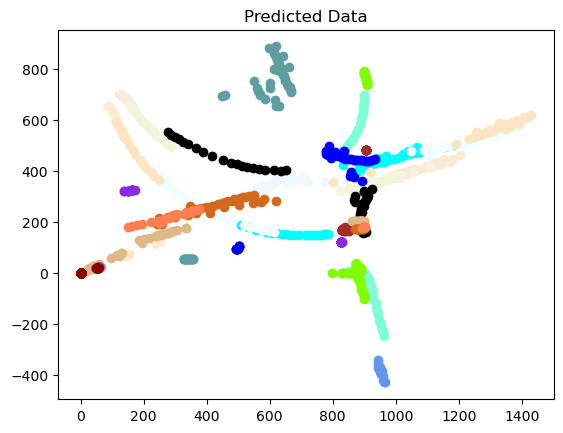

In [44]:
n= 2 # test sample number

i = 0
x = preddata[n][:,:32, 0]
y = preddata[n][:,:32, 1]
xs = actscene[n][:20,:32, 0]
ys = actscene[n][:20,:32, 1]
xr = acttarget[n][:20,:32, 10]
yr = acttarget[n][:20,:32, 11]
# Pliotting the predicted data
for keys in colors.keys():
    if i < 32:
        plt.scatter(xs[:,i], ys[:,i], color = colors[keys])
        plt.scatter(xr[:,i], yr[:,i], color = colors[keys])
        plt.scatter(x[:,i], y[:,i], color = colors[keys])
        # plt.scatter(xr[:,i], yr[:,i], color = 'red')
        # plt.scatter(x[:,i], y[:,i], color = 'black')
        plt.title('Predicted Data')
        i += 1




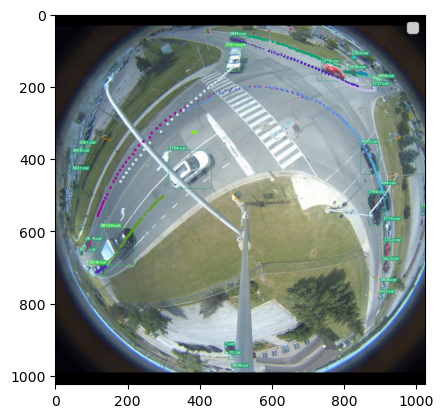

In [22]:
# load an image and plot the ego and target on the image
import matplotlib.pyplot as plt
color = torch.randint(0, 255, (32, 3), dtype=torch.uint8)
img = cv2.imread('RawData/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
n = 30


xs = actscene[n][:,:32, 0]
ys = actscene[n][:,:32, 1]
xr = acttarget[n][:,:32, 0]
yr = acttarget[n][:,:32, 1]
for m in range(32):
    # add points to the coordinates on pred, grth and grth_target
    for i in range(20):
        cv2.circle(img, (int(xs[i,m]), int(ys[i,m])), 2, color[m].tolist(), -1)
        cv2.circle(img, (int(xr[i,m]), int(yr[i,m])), 4, color[m].tolist(), -1)
        # cv2.circle(img, (int(grth_target[i,0]), int(grth_target[i,1])), 4, (255,0,0), -1)
    for i in range(20, 30):
        cv2.circle(img, (int(xr[i,m]), int(yr[i,m])), 4, color[m].tolist(), -1)
#plot polygon on the image
# for i, zone in enumerate(ZoneConf):
#     cv2.polylines(img, [np.array(zone).astype(np.int32)], isClosed=True, color=(0,0,0), thickness=1)
plt.imshow(img)
plt.legend(['Predicted', 'Target'])

In [7]:
colors = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

In [43]:
args.hidden_size

NameError: name 'args' is not defined

In [4]:
import argparse
import os
import torch
import datetime
cwd = os.getcwd()
csvpath = os.path.join(cwd,'Processed','Trj20240506T2121.csv')
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# # Hyperparameters
hidden_size, num_layersGAT, num_layersGRU, expansion,  n_heads = 128, 2,6, 2, 8

learning_rate, schd_stepzise, gamma, epochs, batch_size, patience_limit, clip= 2e-4, 20, 0.5, 300, 128, 40, 1

Headers = ['Frame', 'ID', 'BBx', 'BBy','W', 'L' , 'Cls','Tr1', 'Tr2', 'Tr3', 'Tr4', 'Zone', 'Xreal', 'Yreal']
Columns_to_keep = [2,3,4,5,6,7,8,9,10,11] #['BBx', 'BBy','W', 'L' , 'Cls','Tr1', 'Tr2', 'Tr3', 'Tr4', 'Zone']
#  ['Vx', 'Vy', 'heading',xc,yc, Rc,Rc, SinX,CosX,SinY,CosY, Sin2X,Cos2X, Sin2Y, Cos2Y, Sin3X, Cos3X, Sin3Y, Cos3Y, Sin4X, Cos4X, Sin4Y, Cos4Y]
Columns_to_Predict = [0,1] #['BBx', 'BBy','Xreal', 'Yreal','Vx', 'Vy']
xyid = [0, 1] # the index of x and y  of the Columns_to_Keep in the columns for speed calculation
TrfL_Columns = [7,8,9,10]
NFeatures = len(Columns_to_keep)
input_size = NFeatures + 6 + 8
output_size = len(Columns_to_Predict)
Nusers, NZones = 32, 9
Nnodes, NTrfL, sl, sw, sn  = Nusers+NZones, 4, 20, 1, 5
future = 30
Centre = [512,512]

sos = torch.tensor([1022,1022], device=device)
eos = torch.tensor([1021,1021], device=device)

generate_data = False #  Add class by loading the CSV file
# generate_data = True #  Add class by loading the CSV file
loadData = not generate_data      # load the class from the saved file
Train = True # It's for training the model with the prepared data
test_in_epoch = True # It's for testing the model in each epoch
model_from_scratch = True # It's for creating model from scratch
load_the_model = not model_from_scratch # It's for loading model
Seed = loadData # If true, it will use the predefined seed to load the indices
only_test = False # It's for testing the model only
concat = False



LR = [learning_rate] #, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]
# LR = [1e-2]
HS = [128] #, 32, 64, 128, 256, 512, 1024]
NL = [num_layersGAT] #, 2, 3, 4]
BS = [batch_size] #, 32, 64, 128, 256, 512, 1024]

csvpath ='/home/abdikhab/New_Idea_Traj_Pred/RawData/TrfZonXYCam.csv'
Zoneconf_path ='/home/abdikhab/New_Idea_Traj_Pred/utilz/ZoneConf.yaml'
dataset_path = os.path.join(os.getcwd(), 'Pickled')
ct = datetime.datetime.now().strftime("%m-%d-%H-%M")
print(f"Total  # of GPUs {torch.cuda.device_count()}")
# spread the model to multiple GPUs
print(f"Using {device} device")


# Use argparse to get the parameters
parser = argparse.ArgumentParser(description='Trajectory Prediction')
parser.add_argument('--ct', type=str, default=ct, help='Current time')
parser.add_argument('--Zonepath', type=str, default=Zoneconf_path, help='Zone Conf path')
parser.add_argument('--Nfeatures', type=int, default=NFeatures, help='Number of features')
parser.add_argument('--Nnodes', type=int, default=Nnodes, help='Number of nodes')
parser.add_argument('--NZones', type=int, default=NZones, help='Number of zones')
parser.add_argument('--NTrfL', type=int, default=NTrfL, help='Number of traffic lights')
parser.add_argument('--sl', type=int, default=sl, help='Sequence length')
parser.add_argument('--future', type=int, default=future, help='Future length')
parser.add_argument('--sw', type=int, default=sw, help='Sliding window')
parser.add_argument('--sn', type=int, default=sn, help='Sliding number')
parser.add_argument('--Columns_to_keep', type=list, default=Columns_to_keep, help='Columns to keep')
parser.add_argument('--Columns_to_Predict', type=list, default=Columns_to_Predict, help='Columns to predict')
parser.add_argument('--TrfL_Columns', type=list, default=TrfL_Columns, help='Traffic light columns')
parser.add_argument('--Nusers', type=int, default=Nusers, help='Number of maneuvers')
parser.add_argument('--sos', type=int, default=sos, help='Start of sequence')
parser.add_argument('--eos', type=int, default=eos, help='End of sequence')
parser.add_argument('--xyidx', type=list, default=xyid, help='X and Y index')
parser.add_argument('--Centre', type=list, default=Centre, help='Centre')

parser.add_argument('--input_size', type=int, default=input_size, help='Input size')
parser.add_argument('--hidden_size', type=int, default=hidden_size, help='Hidden size')
parser.add_argument('--num_layersGAT', type=int, default=num_layersGAT, help='Number of layers')
parser.add_argument('--num_layersGRU', type=int, default=num_layersGRU, help='Number of layers')
parser.add_argument('--output_size', type=int, default=output_size, help='Output size')
parser.add_argument('--n_heads', type=int, default=n_heads, help='Number of heads')
parser.add_argument('--concat', type=bool, default=concat, help='Concat')
parser.add_argument('--dropout', type=float, default=0.001, help='Dropout')
parser.add_argument('--leaky_relu_slope', type=float, default=0.2, help='Leaky relu slope')
parser.add_argument('--expansion', type=int, default=expansion, help='Expantion')


parser.add_argument('--epochs', type=int, default=epochs, help='Number of epochs')
parser.add_argument('--learning_rate', type=float, default=learning_rate, help='Learning rate')
parser.add_argument('--batch_size', type=int, default=batch_size, help='Batch size')
parser.add_argument('--patience_limit', type=int, default=patience_limit, help='Patience limit')
parser.add_argument('--schd_stepzise', type=int, default=schd_stepzise, help='Scheduler step size')
parser.add_argument('--gamma', type=float, default=gamma, help='Scheduler Gamma')


parser.add_argument('--only_test', type=bool, default=only_test, help='Only test')
parser.add_argument('--generate_data', type=bool, default=generate_data, help='Generate data')
parser.add_argument('--loadData', type=bool, default=loadData, help='Load data')
parser.add_argument('--Train', type=bool, default=Train, help='Train')
parser.add_argument('--test_in_epoch', type=bool, default=test_in_epoch, help='Test in epoch')
parser.add_argument('--model_from_scratch', type=bool, default=model_from_scratch, help='Model from scratch')
parser.add_argument('--load_the_model', type=bool, default=load_the_model, help='Load the model')
parser.add_argument('--Seed', type=bool, default=Seed, help='Seed')
parser.add_argument('--device', type=str, default=device, help='device')

args, unknown = parser.parse_known_args()

Total  # of GPUs 4
Using cuda:3 device


usage: ipykernel_launcher.py [-h] [--ct CT] [--Zonepath ZONEPATH]
                             [--Nfeatures NFEATURES] [--Nnodes NNODES]
                             [--NZones NZONES] [--NTrfL NTRFL] [--sl SL]
                             [--future FUTURE] [--sw SW] [--sn SN]
                             [--Columns_to_keep COLUMNS_TO_KEEP]
                             [--Columns_to_Predict COLUMNS_TO_PREDICT]
                             [--TrfL_Columns TRFL_COLUMNS] [--Nusers NUSERS]
                             [--sos SOS] [--eos EOS] [--xyidx XYIDX]
                             [--Centre CENTRE] [--input_size INPUT_SIZE]
                             [--hidden_size HIDDEN_SIZE]
                             [--num_layersGAT NUM_LAYERSGAT]
                             [--num_layersGRU NUM_LAYERSGRU]
                             [--output_size OUTPUT_SIZE] [--n_heads N_HEADS]
                             [--concat CONCAT] [--dropout DROPOUT]
                             [--leaky_relu_sl

SystemExit: 2

/home/abdikhab/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [20]:
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = nx.from_edgelist(edgindx)
fig = plt.figure(figsize=(10, 10))
nx.draw(nx_graph, with_labels=True)

torch.Size([20])

In [19]:
color[0].tolist()

[238, 84, 42]

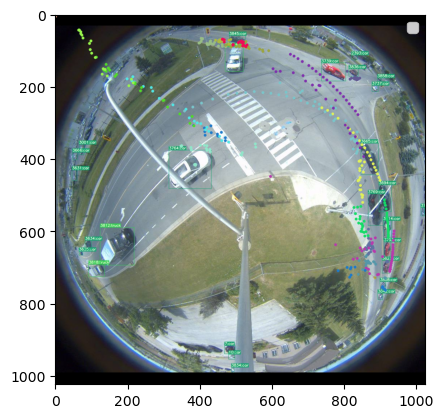

In [ ]:
#Check if the target is in the zone
for i in range(len(grth)):
    print(zonefinder(grth[i,0]*1024,grth[i,1]*1024, ZoneConf))

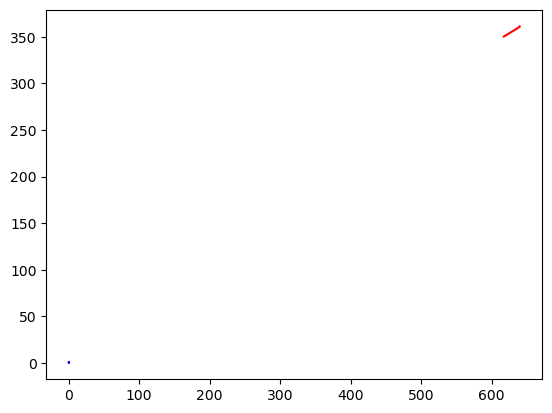

In [59]:
# Plotting all of the predicted data
for i in range(20, 21):
    plt.plot(Predicteddata[-1][i,:,0].to('cpu'), Predicteddata[-1][i,:,1].to('cpu'), 'r')
    plt.plot(ego_gt[i][:,0], ego_gt[i][:,1], 'b')

# plt.scatter(x,y, marker='x', color='r')
# plt.scatter(gyx, gyy, marker='*', color='b')
#plt.scatter(groundtruthx[i][:,0], groundtruthx[i][:,1], marker='o', color='g')

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import os
import math
from convlstm import ConvLSTMCell
from utils import *
from lstm_traj import *
from LSTM import *
#from socialconv.model import highwayNet
#from torchviz import make_dot
# Load the data
cwd = os.getcwd()
csvpath = os.path.join(cwd,'Processed','Trj20240111T2201.csv')
# # Hyperparameters
input_size, hidden_size, num_layers, output_size, epochs, learning_rate = 10, 64, 4, 1, 200, 1e-2
sequence_length, sw , shift, batch_size = 100, 10, 8, 1
sl = sequence_length
add_class = True #  Add class by loading the CSV file
load_class = not add_class      # load the class from the saved file
Train = True # It's for training the model with the prepared data
test_in_epoch = True # It's for testing the model in each epoch
model_from_scratch = True # It's for creating model from scratch
load_the_model = not model_from_scratch # It's for loading model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create datasets

if add_class:
    df = loadcsv(csvpath)
    dataset, maxdata, mindata = def_class(df, sw, sl, shift, output_size, input_size, normalize = False)
    
if load_class:
    dataset = torch.load(os.path.join(os.getcwd(),'Pickled','datasetTorch.pt'))
    normpar = torch.load(os.path.join(os.getcwd(),'Pickled','normpar.pt'))
    print('dataset loaded')
print("Dataset total length is", len(dataset))

# Create train and test sets
train_loader, test_loader, val_loader = prep_data(dataset, batch_size)

Using GPU
normalizing data
dataset saved
Dataset total length is 14478
Train size: 13030 Test size: 1447 Validation size: 1


**This part Summarizes the txt files**

In [ ]:
# load the log.txt file and append to txt
txt = []
tmp = "Hellp"
n=0
j = 0
with open(os.path.join(os.getcwd(),'logs', 'log-05-07-19-13.txt'), 'r') as file:
    logs = file.read()
    for log in logs.split('\n'):
        if tmp.startswith('Average') and log.startswith(' Accuracy'):
            tmp1 = log
            tmp2 = tmp
        if log.startswith('Learning'):
            j += 1
            if j == 1:
                txt.append(log)
            else:
                txt.append(tmp1)
                txt.append(tmp2) 
                txt.append(log)
        tmp = log

with open(os.path.join(os.getcwd(),'logs', 'Summary of log-05-07-19-13.txt'), 'w') as file:
    for log in txt:
        file.write(log + '\n')